STAGE 1 DATA PREPROCESSING

In [1]:
#GET THE DATA FIRST

In [2]:
import tensorflow as tf
import librosa as lr
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import os
from IPython.display import display, Audio
from sklearn.model_selection import train_test_split

In [3]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

In [4]:
#EXTRACT INPUTS AND TARGETS

In [5]:
X_mfccs = np.load('../util/X_mfccs_2000.npy')
Y = np.load('../util/labels_2000.npy')


In [6]:
#LOAD TRAIN AND TEST SPLITS

In [7]:
X_train_mfcc, X_test_mfcc, y_train, y_test = train_test_split(X_mfccs,Y,test_size=0.1)
print(X_train_mfcc.shape)
print(y_train.shape)

(98919, 32, 13)
(98919,)


In [8]:
mu = np.mean(X_train_mfcc,axis=0)
std_dev = np.std(X_train_mfcc,axis=0)
X_train_mfcc -= mu
X_test_mfcc -= mu
X_train_mfcc /= std_dev
X_test_mfcc /= std_dev
print(X_train_mfcc.shape)

(98919, 32, 13)


In [9]:
X_train_mfcc = X_train_mfcc[...,np.newaxis]

In [10]:
X_train_mfcc[0].shape
X_train_mfcc.shape

(98919, 32, 13, 1)

STAGE 2 BUILDING AND COMPILING THE MODEL

In [11]:
#BUILD THE MODEL

In [12]:
# model_mfcc = tf.keras.Sequential()

#conv layer 1
mfcc_input = tf.keras.layers.Input(shape=X_train_mfcc[0].shape, name='mfcc_input')
conv1 = tf.keras.layers.Conv2D(128,(3,3),
                                 activation='relu',
                                 input_shape=X_train_mfcc[0].shape,
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001))(mfcc_input)
norm1 = tf.keras.layers.BatchNormalization()(conv1)
pool1 = tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same')(norm1)

#conv layer 2
conv2 = tf.keras.layers.Conv2D(64,(3,3),
                                 activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001))(pool1)
norm2 = tf.keras.layers.BatchNormalization()(conv2)
pool2 = tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same')(norm2)


#conv layer 3
conv3 = tf.keras.layers.Conv2D(32,(2,2),
                                 activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001))(pool2)
norm3 = tf.keras.layers.BatchNormalization()(conv3)
pool3 = tf.keras.layers.MaxPool2D((2,2),strides=(2,2),padding='same')(norm3)



# #flatten output
flat = tf.keras.layers.Flatten()(pool3)
dense1 = tf.keras.layers.Dense(64,activation = 'relu')(flat)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)

dense2 = tf.keras.layers.Dense(64,activation = 'relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

In [13]:
#output layer
output = tf.keras.layers.Dense(1,activation='sigmoid')(drop2)
model = tf.keras.Model(inputs=[mfcc_input],outputs=output)

In [14]:
#COMPILE

In [15]:
op = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=op, metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mfcc_input (InputLayer)      [(None, 32, 13, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 11, 128)       1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 11, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 6, 128)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 4, 64)         73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 4, 64)         256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 2, 64)         

In [16]:
#FIT

In [17]:
result = model.fit([X_train_mfcc],y_train, epochs = EPOCHS, batch_size = BATCH_SIZE,validation_split = 0.2)

Epoch 1/20
1237/1237 [==============================] - 105s 85ms/step - loss: 0.5747 - accuracy: 0.7884 - val_loss: 0.5191 - val_accuracy: 0.8161
Epoch 2/20
1237/1237 [==============================] - 103s 83ms/step - loss: 0.5299 - accuracy: 0.8075 - val_loss: 0.4987 - val_accuracy: 0.8193
Epoch 3/20
1237/1237 [==============================] - 109s 88ms/step - loss: 0.5070 - accuracy: 0.8109 - val_loss: 0.4823 - val_accuracy: 0.8207
Epoch 4/20
1237/1237 [==============================] - 97s 79ms/step - loss: 0.4894 - accuracy: 0.8128 - val_loss: 0.4724 - val_accuracy: 0.8207
Epoch 5/20
1237/1237 [==============================] - 100s 81ms/step - loss: 0.4730 - accuracy: 0.8145 - val_loss: 0.4717 - val_accuracy: 0.8174
Epoch 6/20
1237/1237 [==============================] - 113s 92ms/step - loss: 0.4588 - accuracy: 0.8174 - val_loss: 0.4543 - val_accuracy: 0.8234
Epoch 7/20
1237/1237 [==============================] - 110s 89ms/step - loss: 0.4485 - accuracy: 0.8182 - val_loss: 0.

In [18]:
history = result.history
tr_acc = history['accuracy']
val_acc = history['val_accuracy']
epochs = range(1, len(tr_acc)+1)

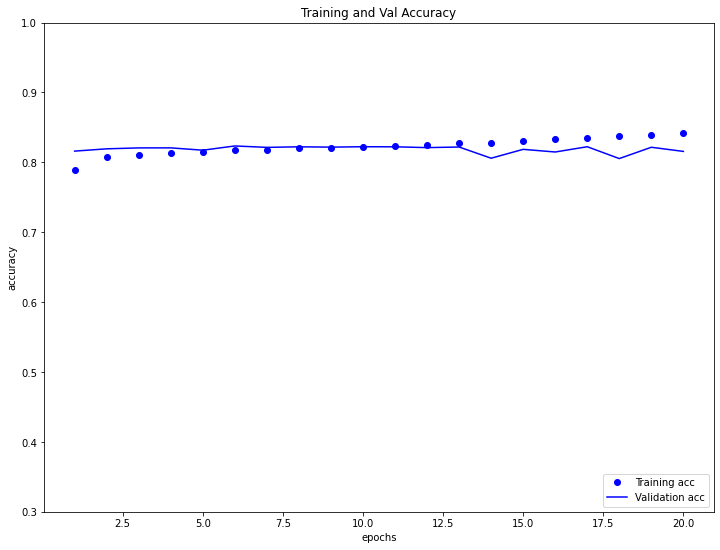

In [19]:
plt.figure(figsize=(12,9))
plt.plot(epochs,tr_acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Val Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim((0.3,1))
plt.show()

In [24]:
#INFERENCE:

In [27]:
results = model.evaluate([X_test_mfcc],y_test)

537/537 [==============================] - 2s 3ms/step - loss: 0.5705 - accuracy: 0.7836


In [28]:
#ERROR ANALYSIS:

In [30]:
predictions = model.predict([X_test_mfcc])
valid_indexes = []
invalid_indexes=[]
for i in range(len(y_test)):
    if(y_test[i] == 0):
        invalid_indexes.append(i)
    else:
        valid_indexes.append(i)

In [31]:
def get_pred(val):
    return np.around(val)
print("PERFORMANCE ON POSITIVE EXAMPLES:")
total_pos = 0
total_right_pops = 0
for i in valid_indexes:
    total_pos += 1
    if(get_pred(predictions[i]) == get_pred(y_test[i])):
        total_right_pops += 1
    print("Prediction: ",get_pred(predictions[i]),". Label: ", get_pred(y_test[i]))
    
print("TOTAL POSITIVE EXMPLES: ", total_pos)
print("TOTAL CORRECT POSITIVE:", total_right_pops)
print("POSITIVE EXAMPLES ACC: ", total_right_pops/total_pos)

PERFORMANCE ON POSITIVE EXAMPLES:
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Predic

Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction

Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction

Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction

Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction

Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction

Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction

Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction

Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction

Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction

Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction

Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction

Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [0.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction:  [1.] . Label:  1
Prediction

In [ ]:
print("PERFORMANCE ON NEGATIVE EXAMPLES:")
total_neg = 0
total_right_neg = 0
for i in invalid_indexes:
    total_neg += 1
    if(get_pred(predictions[i]) == get_pred(y_test[i])):
        total_right_neg += 1
    print("Prediction: ", get_pred(predictions[i]),". Label: ",get_pred(y_test[i]))
print("TOTAL NEGATIVE EXMPLES: ", total_neg)
print("TOTAL CORRECT NEGATIVE:", total_right_neg)
print("NEGATIVE EXAMPLES ACC: ", total_right_neg/total_neg)

In [ ]:
print("TOTAL EXMPLES: ", total_neg + total_pos)
print("TOTAL CORRECT :", total_right_neg + total_right_pops)
print("ACC: ", (total_right_neg + total_right_pops)/(total_neg + total_pos))

In [ ]:
#OLD MODEL

In [ ]:
model = tf.keras.Sequential()

#conv layer 1
model.add(tf.keras.layers.Conv2D(64,(3,3),
                                 activation='relu',
                                 input_shape=X_train[0].shape,
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same'))

#conv layer 2
model.add(tf.keras.layers.Conv2D(32,(3,3),
                                 activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D((3,3),strides=(2,2),padding='same'))

#conv layer 3
model.add(tf.keras.layers.Conv2D(32,(2,2),
                                 activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D((2,2),strides=(2,2),padding='same'))

#flatten output
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))

#flatten output
model.add(tf.keras.layers.Dense(64,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))

#output layer
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
op = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='binary_crossentropy',optimizer=op, metrics=['accuracy'])
model.summary()

TRAIN MODEL

In [ ]:
model.fit(X_train,y_train, epochs = EPOCHS, batch_size = BATCH_SIZE,validation_split = 0.2)